# Double Q-Learning

This notebook shows the tabular reinforcement learning algorithm, Double Q-Learning applied to the Taxi problem (it also works on CliffWalking and FrozenLake) from Open AI's gym. Double Q-Learning is an off-policy Temporal Difference control algorithm. Two action value functions, $Q_1$ and $Q_2$ are used for this method, which are both used for estimating the discounted return and selecting the optimal action, hence the name double learning. This algorithm improves on the standard Q-Learning algorithm by reducing the impact of maximization bias. Maximimization bias can occur when there is uncertainty in the return of the actions in a given state. For example if the return of all the actions in a state is 0, but the estimated returns are non-zero, (some positive and others negative), then the maximum of the values will be positive. This results in a positive bias, which we call a maximization bias.  

The action $A$ is selected by using the $\epsilon$-greedy policy on $(Q_1 + Q_2) / 2$, then with 50% probability the following update is performed:
$$Q_1(S_t, A_t) \leftarrow Q_1(S_t, A_t) + \alpha [R_{t + 1} + \gamma Q_2(S_{t + 1}, \argmax_{a}Q_1(S_{t + 1}, a)) - Q_1(S_t, A_t)]$$
, otherwise the following update is performed:
$$Q_2(S_t, A_t) \leftarrow Q_2(S_t, A_t) + \alpha [R_{t + 1} + \gamma Q_1(S_{t + 1}, \argmax_{a}Q_2(S_{t + 1}, a)) - Q_2(S_t, A_t)]$$
, where $Q1$ and $Q2$ are the learned action-value functions, $R$ is the reward, $A$ is the action, $\alpha$ is the step size, $\gamma$ is the discount rate and $t$ is the time step.

The learned action-value functions $Q1$ and $Q2$ directly approximates the optimal action-value function $q_*$ independent of the policy being followed. For more information on Double Q-Learning see section 6.7 of [Reinforcement Learning: An Introduction](http://incompleteideas.net/book/RLbook2018.pdf).

In [1]:
import os
import gymnasium as gym
import numpy as np
import random
from IPython.display import Video
import matplotlib.pyplot as plt

In [2]:
# Type of environment, options include:
# Taxi-v3, CliffWalking-v0, FrozenLake-v1
ENV_TYPE = "Taxi-v3"

# Save videos from training
SAVE_VIDEOS = False
VIDEOS_ROOT_DIR = './videos/double_q_learning/'

In [3]:
# Create the environment
env = gym.make(ENV_TYPE, render_mode="rgb_array")

# Number of possible states and actions
num_states = env.observation_space.n 
num_actions = env.action_space.n

# Action-value function, 
# initialized to 0 for all states and actions
Q1 = np.zeros([num_states, num_actions])
Q2 = np.zeros([num_states, num_actions])

## Create An $\epsilon$-Greedy Policy 

In [4]:
def policy_fn(state, Q, epsilon, num_actions):
    # Create a distribution of actions and divide the epsilon probability between all actions
    action_dist = np.ones(num_actions, dtype=float) * epsilon / num_actions
    # Find the best action
    best_action = np.argmax(Q[state, :])
    # Set probability for the best action to (1 - epsilon)
    action_dist[best_action] += (1.0 - epsilon)
    return action_dist

## Learn The Optimal Action-Value Function

In [5]:
# Number of episodes to train on
episodes = 401
# Sliding window for episode evaluation (needs to be less than episodes)
episode_window = 5
# Return (accumulation of all rewards over an episode)
G = 0
returns = []
# Discount ratio
gamma = 0.99
# Step size
alpha = 0.618
# Probability of taking a non-greedy action
epsilon = 0.01

env = gym.make(ENV_TYPE, render_mode="rgb_array")
env = gym.wrappers.RecordEpisodeStatistics(env, buffer_length=episodes)

if SAVE_VIDEOS:
    os.makedirs(VIDEOS_ROOT_DIR, exist_ok=True)
    env = gym.wrappers.RecordVideo(
        env=env, 
        video_folder=VIDEOS_ROOT_DIR,
        episode_trigger=lambda episode: episode % 100 == 0,
        video_length=0,
        name_prefix=ENV_TYPE
        )
        

for episode in range(1, episodes+1):
    terminated, truncated = False, False
    G, reward = 0, 0
    state, info = env.reset()
    while not terminated:
        # Select the action following the epsilon-greedy policy
        action_dist1 = policy_fn(state, Q1, epsilon, num_actions)
        action_dist2 = policy_fn(state, Q2, epsilon, num_actions)
        action_dist = (action_dist1 + action_dist2) / 2
        action = np.random.choice(np.arange(num_actions), p=action_dist)
        # Take the action and observe reward and next state
        next_state, reward, terminated, truncated, info = env.step(action)
        # Randomly update action value function Q1 or Q2
        rand_value = random.uniform(0, 1)
        if rand_value > 0.5:
            # Update the expected return for the action-value function Q1
            Q1[state, action] += alpha * (reward + gamma * Q2[next_state, np.argmax(Q1[next_state, :])] - Q1[state, action]) 
        else:
            # Update the expected return for the action-value function Q2
            Q2[state, action] += alpha * (reward + gamma * Q1[next_state, np.argmax(Q2[next_state, :])] - Q2[state, action]) 
        G += reward
        state = next_state

    returns.append(G)

    if episode % 10 == 0:
        print(f'Episode: {episode} Return: {G}')

Episode: 10 Return: -19
Episode: 20 Return: -510
Episode: 30 Return: -420
Episode: 40 Return: -1022
Episode: 50 Return: -27
Episode: 60 Return: -23
Episode: 70 Return: -56
Episode: 80 Return: -35
Episode: 90 Return: -52
Episode: 100 Return: -357
Episode: 110 Return: -140
Episode: 120 Return: -17
Episode: 130 Return: -583
Episode: 140 Return: -205
Episode: 150 Return: -6
Episode: 160 Return: 7
Episode: 170 Return: -46
Episode: 180 Return: -129
Episode: 190 Return: 3
Episode: 200 Return: 13
Episode: 210 Return: 8
Episode: 220 Return: 6
Episode: 230 Return: -11
Episode: 240 Return: 13
Episode: 250 Return: -66
Episode: 260 Return: 15
Episode: 270 Return: -81
Episode: 280 Return: 9
Episode: 290 Return: -55
Episode: 300 Return: 6
Episode: 310 Return: 8
Episode: 320 Return: 1
Episode: 330 Return: -8
Episode: 340 Return: 5
Episode: 350 Return: 8
Episode: 360 Return: 7
Episode: 370 Return: 0
Episode: 380 Return: 3
Episode: 390 Return: 3
Episode: 400 Return: 5


## Plot The Results

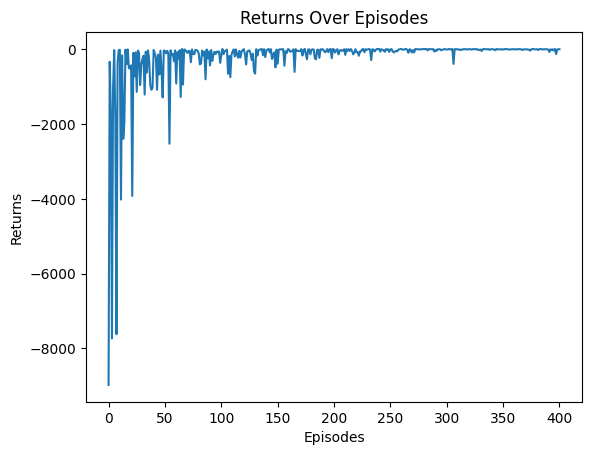

In [6]:
plt.plot(np.arange(episodes), returns)
plt.title("Returns Over Episodes")
plt.xlabel("Episodes")
plt.ylabel("Returns")
plt.show()

## Training Episode Videos

### Episode 0

In [7]:
Video(f"{VIDEOS_ROOT_DIR}/{ENV_TYPE}-episode-0.mp4")

### Episode 100

In [8]:
Video(f"{VIDEOS_ROOT_DIR}/{ENV_TYPE}-episode-100.mp4")

### Episode 200

In [9]:
Video(f"{VIDEOS_ROOT_DIR}/{ENV_TYPE}-episode-200.mp4")

### Episode 300

In [10]:
Video(f"{VIDEOS_ROOT_DIR}/{ENV_TYPE}-episode-300.mp4")

### Episode 400

In [11]:
Video(f"{VIDEOS_ROOT_DIR}/{ENV_TYPE}-episode-400.mp4")

## Render Final Model On An Example

In [12]:
# Run the algorithm in inferencing mode and 
# observe its performance
env = gym.make(ENV_TYPE, render_mode="human")
state, info = env.reset(seed=65)
G = 0
num_steps = 0
terminated = False

while not terminated and not truncated:
    action = np.argmax((Q1[state, :] + Q2[state, :]) / 2) 
    state, reward, terminated, truncated, info = env.step(action)
    G += reward
    num_steps += 1

print(f'Total Reward: {G}, Steps Taken: {num_steps}')

env.close()

Total Reward: 7, Steps Taken: 14
